## 이 데이터는 얼마나 믿을 수 있을까?

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm 
import seaborn as sb
from math import sqrt
from hossam import load_data
import numpy as np
from scipy.stats import t, normaltest, bartlett, levene, f_oneway, ttest_ind
from statsmodels.stats.anova import anova_lm 
from pingouin import anova, welch_anova
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from pandas import DataFrame, melt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

In [2]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('diamonds')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/diamonds.xlsx
[desc] 다이아몬드를 커팅, 색상, 투명도, 가격 및 기타 속성 조사한 데이터 셋 (출처: https://www.kaggle.com/datasets/shivam2503/diamonds)

field    description
-------  -------------------------------------------------------------------
price    다이아몬드 가격 (USD, $326 ~ $18,823)
carat    중량 (0.2~5.01)
cut      컷 품질 (Fair, Good, Very Good, Premium, Ideal)
color    색상 등급 - J (worst) to D (best)
clarity  투명도 등급 (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x        길이 mm (0~10.74)
y        너비 mm (0--58.9)
z        두께 mm (0--31.8)
depth    비율 정보 = z / mean(x, y) = 2 * z / (x + y) (43--79)
table    다이아몬드의 가장 넓은 지점에 비해 상단(테이블)의 너비 (43--95)

데이터셋 크기: (53940, 10)
열 개수: 10
행 개수: 53940
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   price    53940 non-null  int64  
 1   carat    53940 non-null  float64
 2   cut      53940 non

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0


In [ ]:
# 결측치 존재하지 않음을 확인
origin.isna().sum()

price      0
carat      0
cut        0
color      0
clarity    0
x          0
y          0
z          0
depth      0
table      0
dtype: int64

In [ ]:
# 결측치 존재함을 확인
(origin[['x', 'y', 'z']] == 0).any()

x    True
y    True
z    True
dtype: bool

In [6]:
origin[['price','carat','x','y','z','depth','table']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00


In [7]:
df1 = origin.copy()
df1 = df1[(df1['x'] != 0) & (df1['y'] != 0) & (df1['z'] != 0)]
df1

,price,carat,cut,color,clarity,x,y,z,depth,table
0,326,0.23,Ideal,E,SI2,3.95,3.98,2.43,61.5,55.0
1,326,0.21,Premium,E,SI1,3.89,3.84,2.31,59.8,61.0
2,327,0.23,Good,E,VS1,4.05,4.07,2.31,56.9,65.0
3,334,0.29,Premium,I,VS2,4.20,4.23,2.63,62.4,58.0
4,335,0.31,Good,J,SI2,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...,...,...,...
53935,2757,0.72,Ideal,D,SI1,5.75,5.76,3.50,60.8,57.0
53936,2757,0.72,Good,D,SI1,5.69,5.75,3.61,63.1,55.0
53937,2757,0.70,Very Good,D,SI1,5.66,5.68,3.56,62.8,60.0
53938,2757,0.86,Premium,H,SI2,6.15,6.12,3.74,61.0,58.0


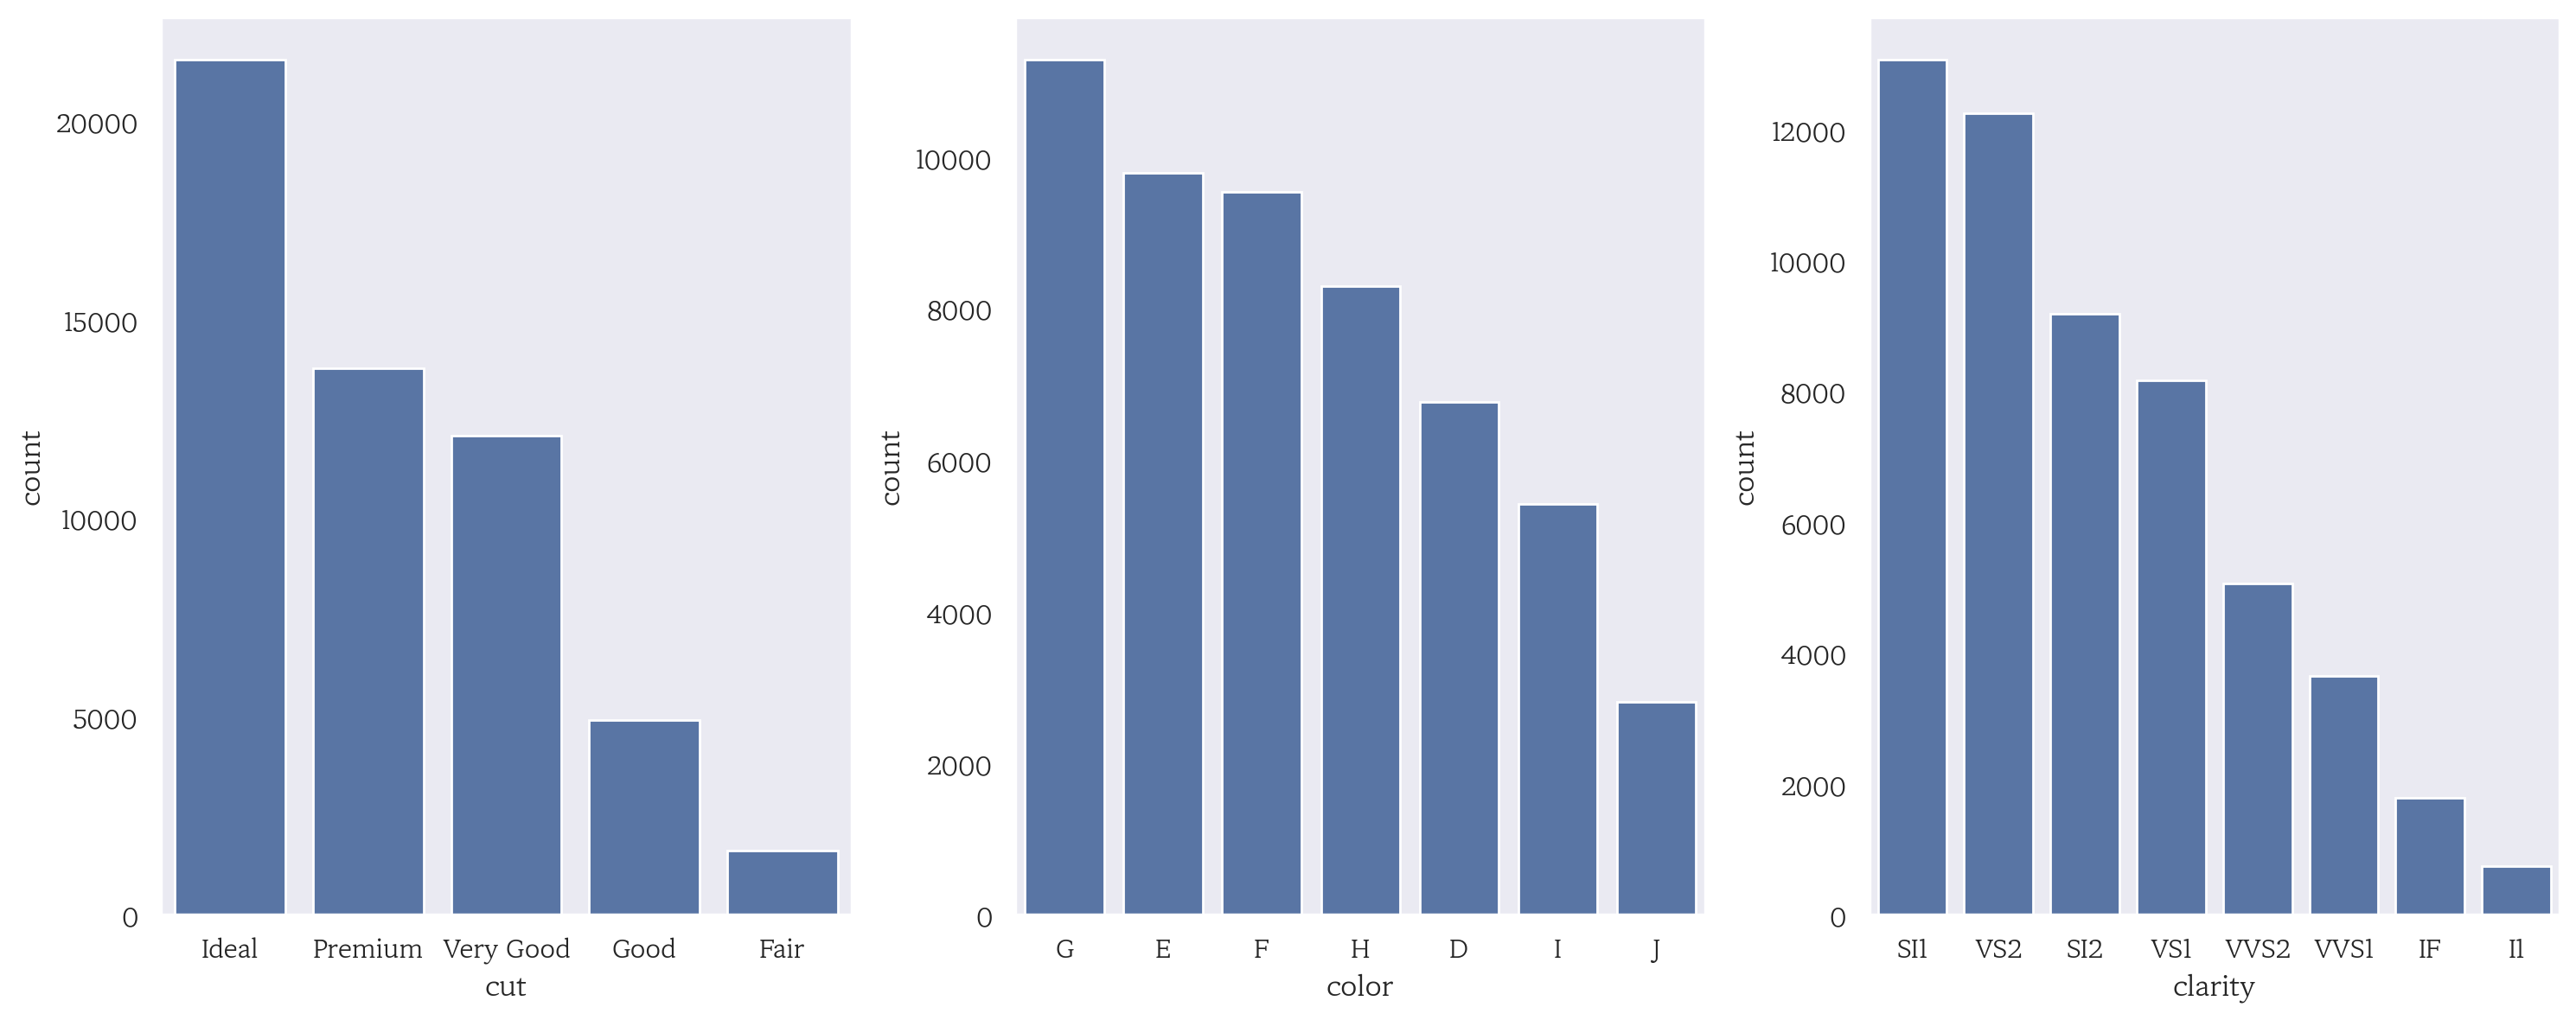

In [ ]:
# plt.subplots(행,열,[figsize =(가로,세로)])
width_px = 3000
height_px = 1200
rows = 1                                                           #서브플롯 사용시 값 변경
cols = 3                                                           #서브플롯 사용시 값 변경
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)


order = df1['cut'].value_counts().sort_values(ascending = False).index
order_color = df1['color'].value_counts().sort_values(ascending = False).index
order_clarity = df1['clarity'].value_counts().sort_values(ascending = False).index
sb.countplot(data=df1, x = 'cut', order = order,ax=ax[0])
sb.countplot(data=df1, x = 'color', order = order_color,ax=ax[1])
sb.countplot(data=df1, x = 'clarity', order = order_clarity, ax=ax[2])

fig.subplots_adjust(wspace = 0.2, hspace = 0.2)

# 출력
plt.tight_layout()
plt.show()
plt.close()


- cut: Ideal에 값이 치중되어 있음.

- 결측치 존재여부 판단 후, x,y,z값 중 0이 존재하는 행(20개)을 삭제하였다. 
- 그 이유는, 결측치가 있는 데이터의 수가 극소수였기 때문이다.

## 미션 2
### price 변수 분포

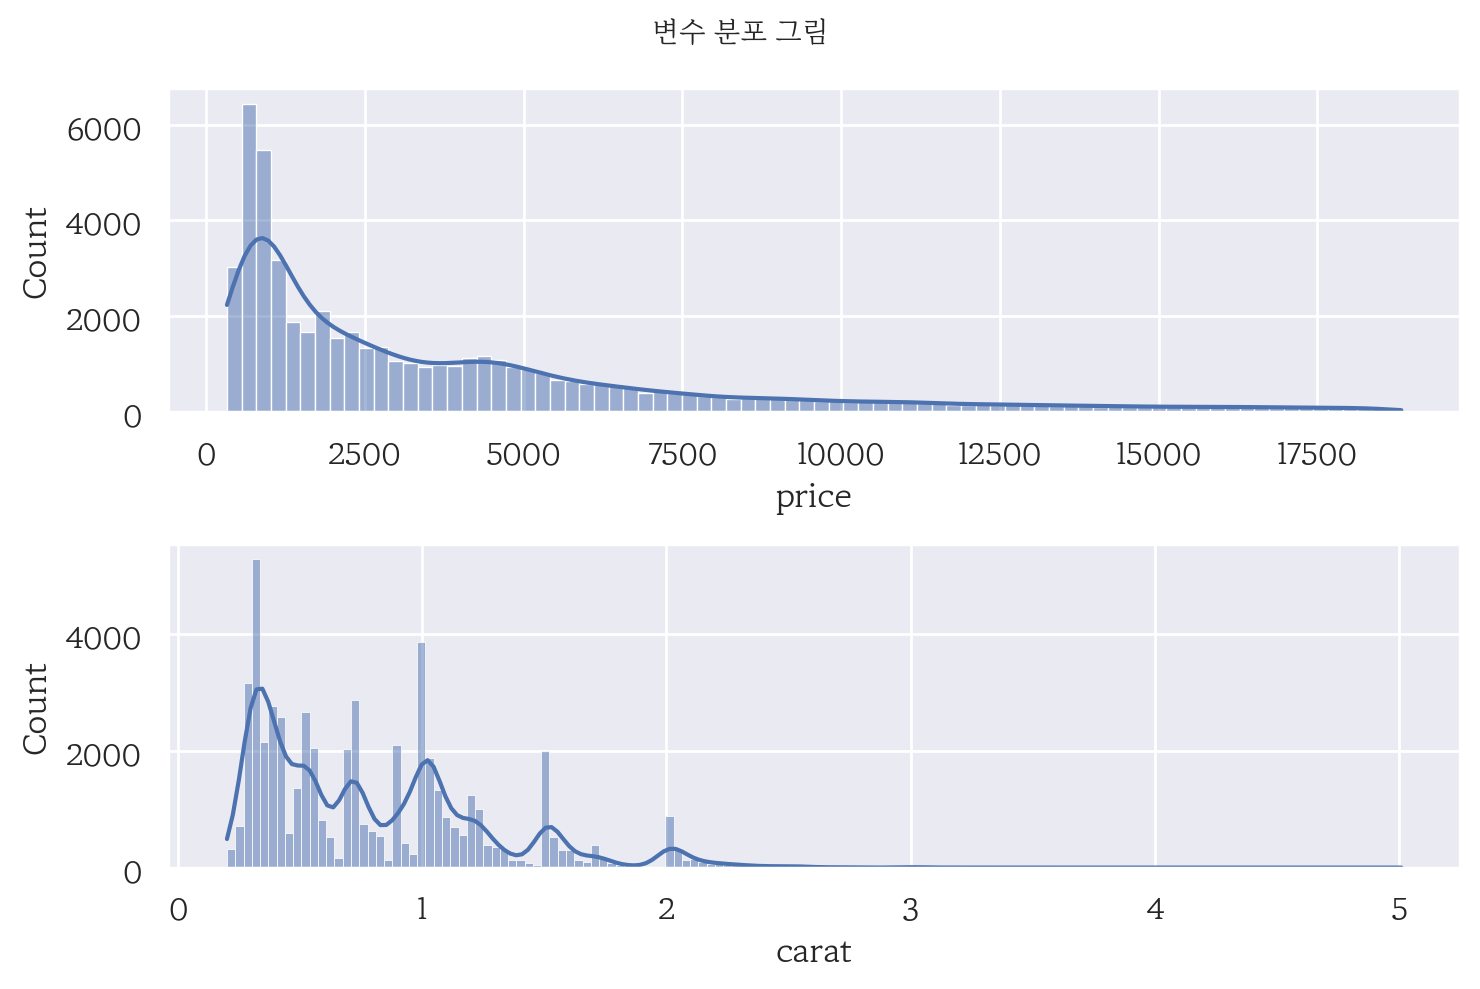

In [25]:
width_px = 1500
height_px = 1000
rows = 2
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# histplot 그리기 
sb.histplot(data =df1, x = 'price', kde = True, alpha = 0.5, ax=ax[0])
sb.histplot(data = df1, x='carat', kde = True, alpha = 0.5, ax=ax[1])

# 그래프 꾸미기
ax[0].grid(True)
ax[1].grid(True) # 배경 격자 표시/숨김
fig.suptitle("변수 분포 그림", fontsize=10)


# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()

- price 데이터의 경우, 0~2500 사이에 값들이 밀집되어있는 것으로 확인된다(우편향 그래프)
- carat 데이터의 경우, 0~1 사이에 데이터가 밀집되어 있는것으로 확인된다(우편향 그래프)

### 인사이트
- 회귀분석을 수행하면 안된다. 정규성, 등분산성을 만족하지 못하였기 때문이다

## 미션 3

### Price 값에 대한 로그변환 후, 전

In [27]:
log_data = np.log(origin['price'])
log_data
target_value = np.log(10)

In [13]:
s, p = normaltest(origin['price'],) # '제시된 값', alternative = 'less, greater'       # 제시된 값 = t검정에서만 
'statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}'.format(s, p, p > 0.05)
# 'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s, p, '대립' if p < 0.05 else '귀무')

'statistic: 15096.650, p-value: 0.000, 정규성 충족 여부: False'

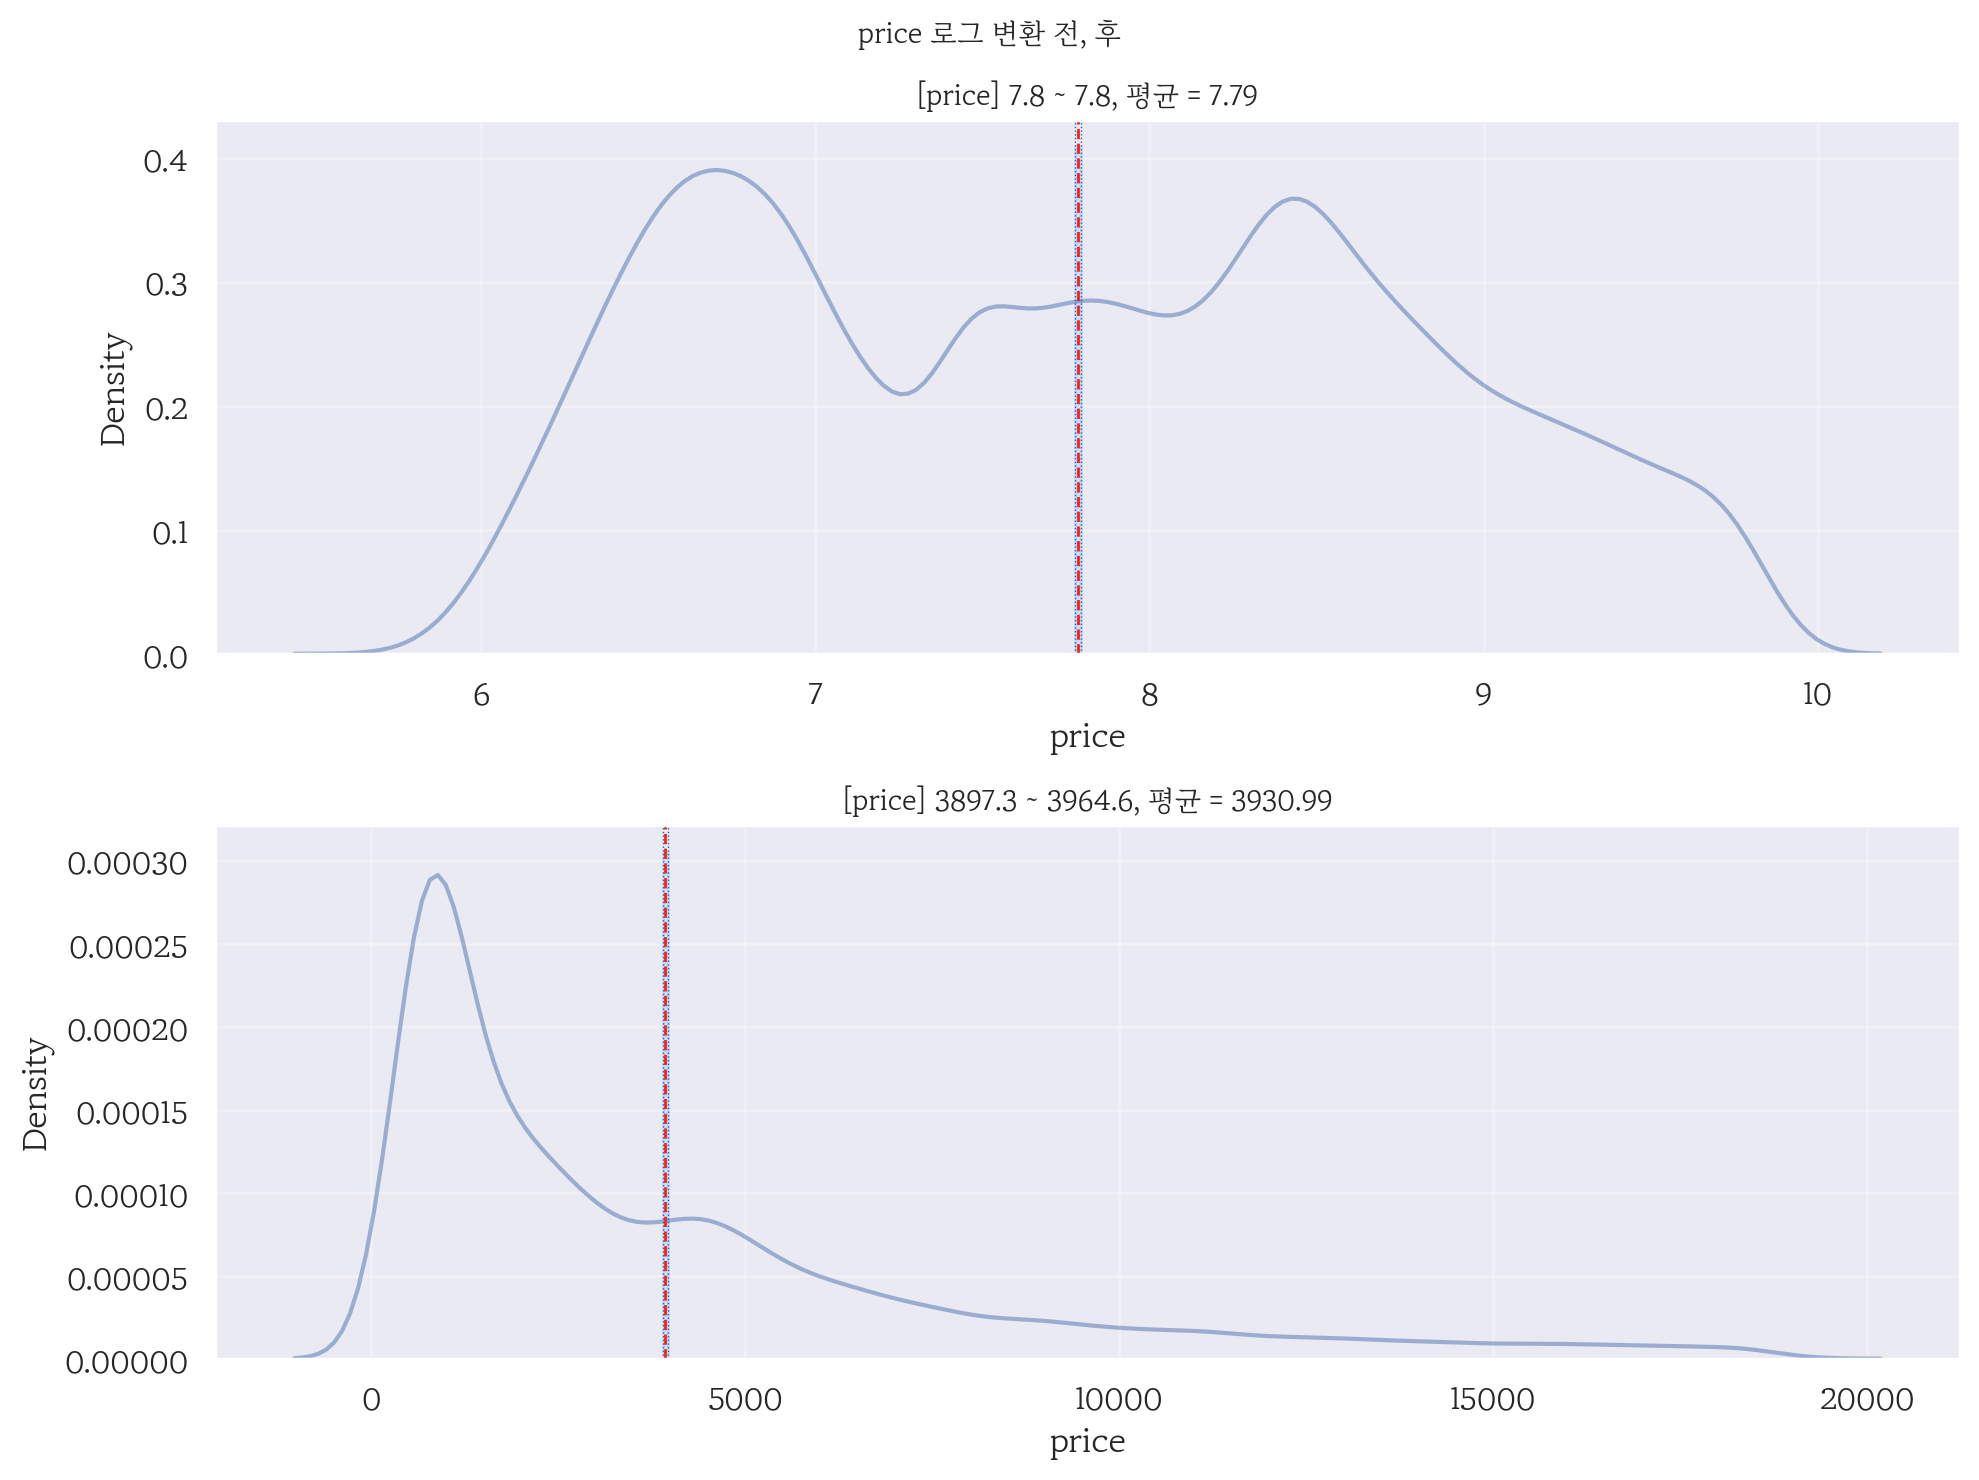

In [43]:
data = log_data
max1 = data.max()
clevel = 0.95
dof1 = len(data) - 1
sp_mean1 = data.mean()
sp_std1 = data.std(ddof=1)
sp_std_error1 = sp_std1 / sqrt(len(data))
cmin1, cmax1 = t.interval(clevel, dof1, loc=sp_mean1, scale=sp_std_error1)

# 두 번째 데이터 통계
data2 = df1['price']
max2 = data2.max()
dof2 = len(data2) - 1
sp_mean2 = data2.mean()
sp_std2 = data2.std(ddof=1)
sp_std_error2 = sp_std2 / sqrt(len(data2))          # ✅ 수정
cmin2, cmax2 = t.interval(clevel, dof2, loc=sp_mean2, scale=sp_std_error2)  # ✅ 수정

width_px = 2000
height_px = 1500
rows = 2
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# kdeplot
sb.kdeplot(data=data, fill=False, alpha=0.5, ax=ax[0])      # palette는 여기서 의미 없음(단일)
sb.kdeplot(data=df1, x='price', alpha=0.5, ax=ax[1])

fig.suptitle("price 로그 변환 전, 후", fontsize=10)

# 신뢰구간 라인
ax[0].axvline(cmin1, linestyle=':', color='#0066ff', linewidth=0.5)
ax[0].axvline(cmax1, linestyle=':', color='#0066ff', linewidth=0.5)
ax[1].axvline(cmin2, linestyle=':', color='#0066ff', linewidth=0.5)
ax[1].axvline(cmax2, linestyle=':', color='#0066ff', linewidth=0.5)

# ylim 가져오기
ymin1, ymax1 = ax[0].get_ylim()
ymin2, ymax2 = ax[1].get_ylim()

# 신뢰구간 음영
ax[0].fill_between([cmin1, cmax1], 0, ymax1, alpha=0.1, color='#0066ff88')
ax[1].fill_between([cmin2, cmax2], 0, ymax2, alpha=0.1, color='#0066ff88')  # ✅ 수정

# 평균선
ax[0].axvline(sp_mean1, linestyle='--', linewidth=1, color='#ff2200')
ax[1].axvline(sp_mean2, linestyle='--', linewidth=1, color='#ff2200')       # ✅ 수정

# grid + title
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)

ax[0].set_title(f'[{data.name}] {cmin1:.1f} ~ {cmax1:.1f}, 평균 = {sp_mean1:0.2f}', fontsize=10)
ax[1].set_title(f'[price] {cmin2:.1f} ~ {cmax2:.1f}, 평균 = {sp_mean2:0.2f}', fontsize=10)  # ✅ 수정

plt.tight_layout()
plt.show()
plt.close()

### carat값에 대한 로그변환 후, 전

In [45]:
log_data2 = np.log(origin['carat'])
log_data2
target_value = np.log(10)

In [47]:
s, p = normaltest(origin['carat'],) # '제시된 값', alternative = 'less, greater'       # 제시된 값 = t검정에서만 
'statistic: {0:.3f}, p-value: {1:.3f}, 정규성 충족 여부: {2}'.format(s, p, p > 0.05)
# 'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s, p, '대립' if p < 0.05 else '귀무')


'statistic: 8926.738, p-value: 0.000, 정규성 충족 여부: False'

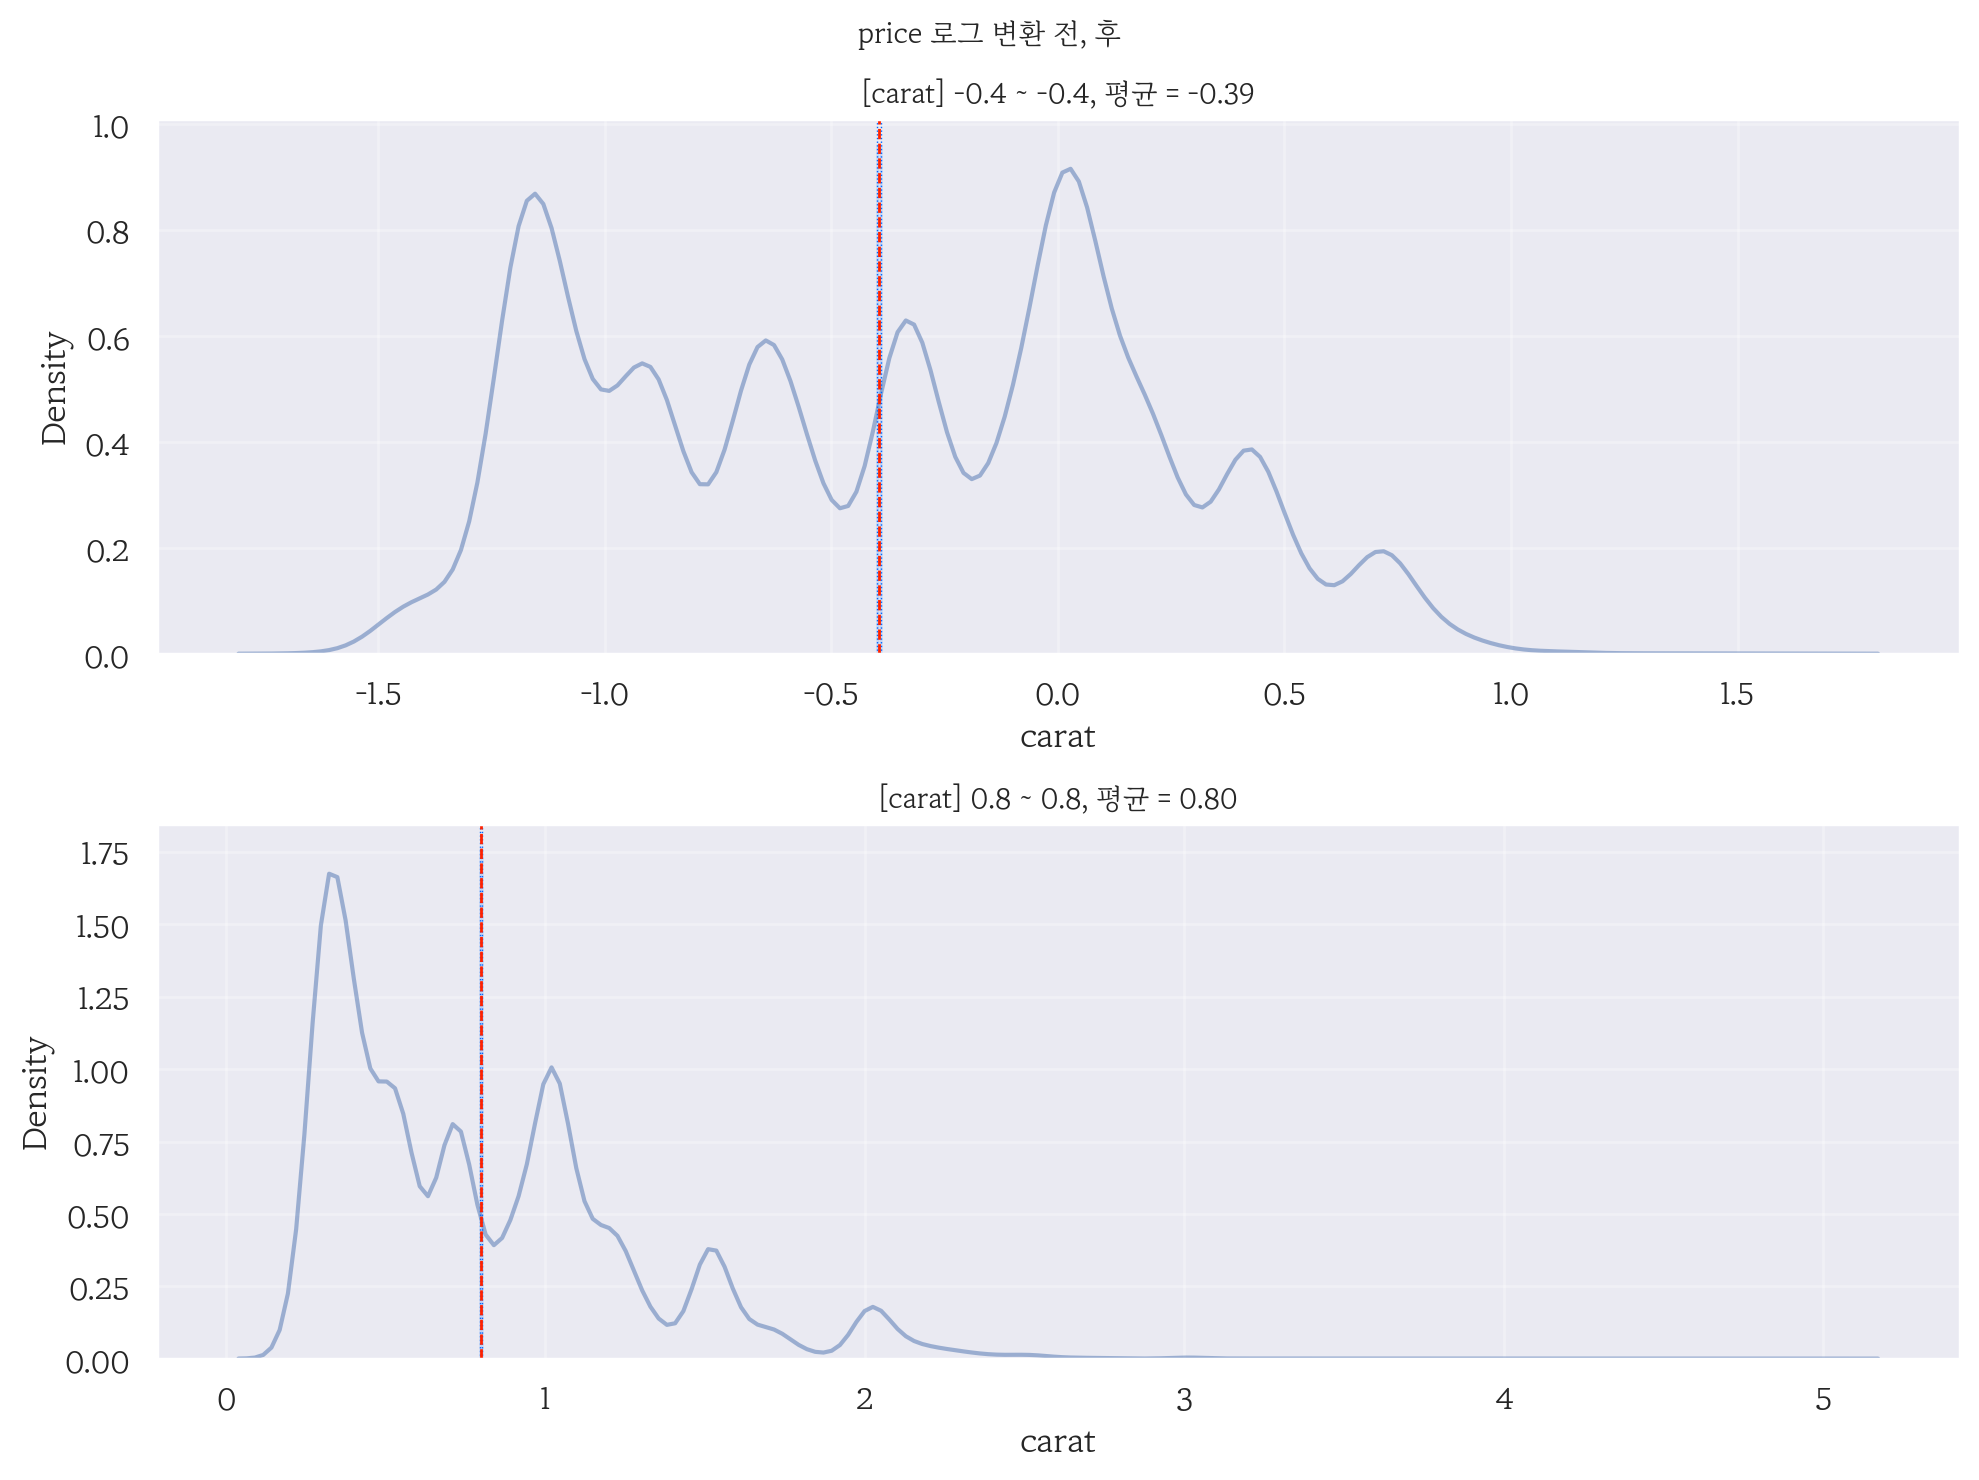

In [48]:
data = log_data2
max1 = data.max()
clevel = 0.95
dof1 = len(data) - 1
sp_mean1 = data.mean()
sp_std1 = data.std(ddof=1)
sp_std_error1 = sp_std1 / sqrt(len(data))
cmin1, cmax1 = t.interval(clevel, dof1, loc=sp_mean1, scale=sp_std_error1)

# 두 번째 데이터 통계
data2 = df1['carat']
max2 = data2.max()
clevel = 0.95
dof2 = len(data2) - 1
sp_mean2 = data2.mean()
sp_std2 = data2.std(ddof=1)
sp_std_error2 = sp_std2 / sqrt(len(data2))          
cmin2, cmax2 = t.interval(clevel, dof2, loc=sp_mean2, scale=sp_std_error2)  

width_px = 2000
height_px = 1500
rows = 2
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# kdeplot
sb.kdeplot(data=data, fill=False, alpha=0.5, ax=ax[0])      # palette는 여기서 의미 없음(단일)
sb.kdeplot(data=df1, x='carat', alpha=0.5, ax=ax[1])

fig.suptitle("price 로그 변환 전, 후", fontsize=10)

# 신뢰구간 라인
ax[0].axvline(cmin1, linestyle=':', color='#0066ff', linewidth=0.5)
ax[0].axvline(cmax1, linestyle=':', color='#0066ff', linewidth=0.5)
ax[1].axvline(cmin2, linestyle=':', color='#0066ff', linewidth=0.5)
ax[1].axvline(cmax2, linestyle=':', color='#0066ff', linewidth=0.5)

# ylim 가져오기
ymin1, ymax1 = ax[0].get_ylim()
ymin2, ymax2 = ax[1].get_ylim()

# 신뢰구간 음영
ax[0].fill_between([cmin1, cmax1], 0, ymax1, alpha=0.1, color='#0066ff88')
ax[1].fill_between([cmin2, cmax2], 0, ymax2, alpha=0.1, color='#0066ff88')  # ✅ 수정

# 평균선
ax[0].axvline(sp_mean1, linestyle='--', linewidth=1, color='#ff2200')
ax[1].axvline(sp_mean2, linestyle='--', linewidth=1, color='#ff2200')       # ✅ 수정

# grid + title
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)

ax[0].set_title(f'[{data.name}] {cmin1:.1f} ~ {cmax1:.1f}, 평균 = {sp_mean1:0.2f}', fontsize=10)
ax[1].set_title(f'[carat] {cmin2:.1f} ~ {cmax2:.1f}, 평균 = {sp_mean2:0.2f}', fontsize=10)  # ✅ 수정

plt.tight_layout()
plt.show()
plt.close()

#### 인사이트
- price, carat 데이터 모두, 로그 변환전 정규성을 충족하지 않는다. 
- 정규성